In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

import src.utils as utils


utils.configure_pd(pd)
utils.configure_plt(plt)


def draw_q(x_curr, y_curr, prop_sd, size):
    qx_draws = stats.norm.rvs(loc=x_curr, scale=prop_sd, size=size)
    qy_draws = []
    for xp in qx_draws:
        q_x_xp = stats.norm.pdf(xp, loc=x_curr, scale=prop_sd)
        q_y_xp = stats.norm.pdf(xp, loc=y_curr, scale=prop_sd)
        u = stats.uniform.rvs()

        if u*q_x_xp <= q_y_xp:
            yp = xp
        else:
            accept = False
            while not accept:
                yp = stats.norm.rvs(loc=y_curr, scale=prop_sd)
                q_x_yp = stats.norm.pdf(yp, loc=x_curr, scale=prop_sd)
                q_y_yp = stats.norm.pdf(yp, loc=y_curr, scale=prop_sd)
                u = stats.uniform.rvs()
                if u*q_y_yp > q_x_yp:
                    accept = True
        qy_draws.append(yp)

    qy_draws = np.array(qy_draws)
    return qx_draws, qy_draws

def log_pi(z):
    return stats.norm.logpdf(z)

def log_acc_ratio(x_curr, x_prop):
    return min(0, log_pi(x_prop) - log_pi(x_curr))

In [3]:
# Draw data for scatter plot
# size = 100000 in paper. This takes O(1 min) to run

x_curr, y_curr, prop_sd, size = .25, 4., np.sqrt(10), 1000
x_prop_vec, y_prop_vec = draw_q(x_curr, y_curr, prop_sd, size)

x_lar = [log_acc_ratio(x_curr, xp) for xp in x_prop_vec]
y_lar = [log_acc_ratio(y_curr, yp) for yp in y_prop_vec]

x_lar, y_lar = np.array(x_lar), np.array(y_lar)
log_u = np.log(stats.uniform.rvs(size=size))

Ax = 1*(log_u <= x_lar)
Ay = 1*(log_u <= y_lar)

x_next = Ax * x_prop_vec + (1 - Ax) * x_curr
y_next = Ay * y_prop_vec + (1 - Ay) * y_curr


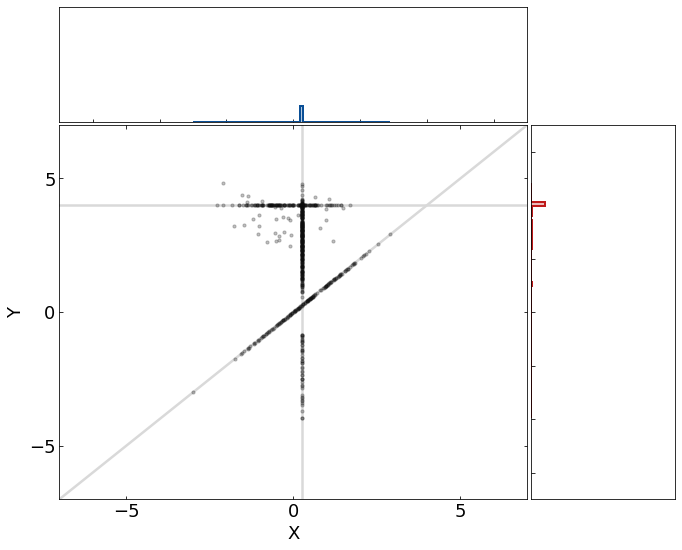

In [6]:
# Figure 2: scatter plot with margin histograms

x,y = x_next, y_next

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(10, 8))
#plt.figure()

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)

ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(x, y, c='.05', alpha=.25, s=10)

ax_scatter.axvline(x_curr, zorder=0, c='.85')
ax_scatter.axhline(y_curr, zorder=0, c='0.85')
ax_scatter.plot([-20,20],[-20,20], zorder=0, c='.85')

# now determine nice limits by hand:
binwidth = 0.25
lim = 7

ax_scatter.set_xlim((-lim, lim))
ax_scatter.set_ylim((-lim, lim))
ax_scatter.grid(b=None)
ax_scatter.set_xlabel('X')
ax_scatter.set_ylabel('Y')

ax_scatter.set_xticks(np.linspace(-5,5,3))
ax_scatter.set_yticks(np.linspace(-5,5,3))

bins = 50
ax_histx.hist(x, bins=bins, color=utils.dark_blue, linewidth=2, histtype='step')
ax_histx.hist(x, bins=bins, color=utils.dark_blue, alpha=.3)

ax_histy.hist(y, bins=bins, color=utils.dark_red, orientation='horizontal',
              linewidth=2, histtype='step')
ax_histy.hist(y, bins=bins, color=utils.dark_red, orientation='horizontal',
              alpha=.3)

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histx.set_ylim(ymax=5000)
ax_histx.set_yticks([])
ax_histx.grid(b=None)

ax_histy.set_ylim(ax_scatter.get_ylim())
ax_histy.set_xlim(xmax=5000)
ax_histy.set_xticks([])
ax_histy.grid(b=None)

plt.show()